In [22]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import stLVG_upload
from stLVG_upload.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from stLVG_upload.viz import match_3D_multi, hist, Sankey, build_3D
from stLVG_upload.metrics import region_statistics

In [2]:
# file_path_1 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151674')
# adata_1 = sc.read_visium(path=file_path_1, count_file='filtered_feature_bc_matrix.h5', load_images=True)
# adata_1.var_names_make_unique(join="++")

# Ann_df_1 = pd.read_csv(os.path.join(file_path_1 , '151674_annotation.txt'),sep ='\t', header=0 , index_col=0)
# Ann_df_1.loc[Ann_df_1['Layer'].isna(),'Layer'] = "unknown"
# adata_1.obs['annotation'] = Ann_df_1.loc[adata_1.obs_names, 'Layer'].astype('category')

In [3]:
# file_path_2 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151675')
# adata_2 = sc.read_visium(path=file_path_2, count_file='filtered_feature_bc_matrix.h5', load_images=True)
# adata_2.var_names_make_unique(join="++")

# Ann_df_2 = pd.read_csv(os.path.join(file_path_2 , '151675_annotation.txt'),sep ='\t', header=0 , index_col=0)
# Ann_df_2.loc[Ann_df_2['Layer'].isna(),'Layer'] = "unknown"
# adata_2.obs['annotation'] = Ann_df_2.loc[adata_2.obs_names, 'Layer'].astype('category')

In [4]:
adata_1=sc.read_h5ad('D:\ppppaper\data\BARISTAseq\Slice_2.h5ad')
adata_1.var_names_make_unique(join="++")
adata_2=sc.read_h5ad('D:\ppppaper\data\BARISTAseq\Slice_3.h5ad')
adata_2.var_names_make_unique(join="++")

In [5]:
# adata_1=sc.read_h5ad(r'D:\ppppaper\data\STARmap\20180419_BZ9_control.h5ad')
# adata_1.var_names_make_unique(join="++")
# adata_2=sc.read_h5ad(r'D:\ppppaper\data\STARmap\20180417_BZ5_control.h5ad')
# adata_2.var_names_make_unique(join="++")

In [6]:
# adata_1=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.14.h5ad')
# adata_1.var_names_make_unique(join="++")
# adata_1.obs['annotation'] = adata_1.obs['ground_truth']
# adata_2=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.19.h5ad')
# adata_2.var_names_make_unique(join="++")
# adata_2.obs['annotation'] = adata_2.obs['ground_truth']

In [7]:
x1_coords=adata_1.obsm['spatial'][:,0]
y1_coords=adata_1.obsm['spatial'][:,1]
x2_coords=adata_2.obsm['spatial'][:,0]
y2_coords=adata_2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [8]:
Cal_Spatial_Net(adata_1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 22764 edges, 2042 cells.
11.147894221351615 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 18824 edges, 1690 cells.
11.138461538461538 neighbors per cell on average.


In [9]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
features[1].shape

torch.Size([1690, 50])

In [11]:
embd0, embd1, norm0, norm1, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 12.94


In [12]:
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def plot_norm_distribution(norm):
    if isinstance(norm, torch.Tensor):
        norm = norm.numpy()
    
    plt.figure(figsize=(10, 4))
    sns.histplot(norm, kde=False, bins=20, color="#E7A9C5", alpha=0.7)
    plt.xlabel("", fontsize=28)
    plt.ylabel("", fontsize=28)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(alpha=0.3)
    plt.show()

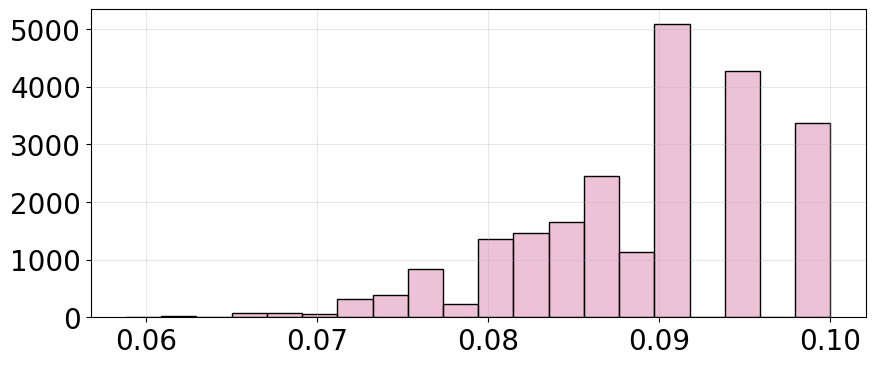

In [14]:
plot_norm_distribution(norm0)

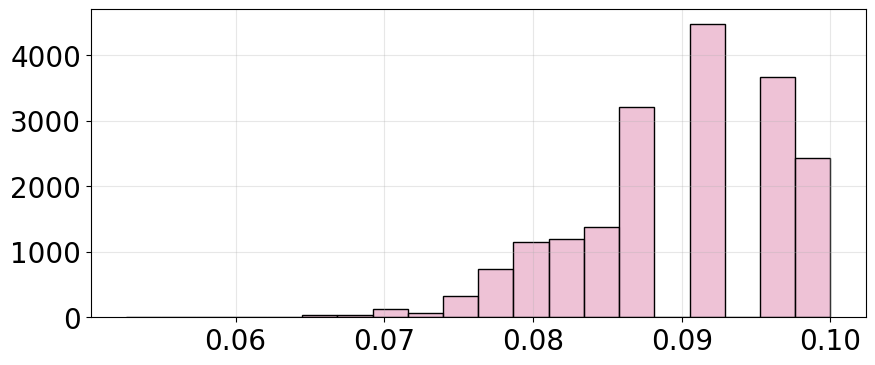

In [15]:
plot_norm_distribution(norm1)

In [16]:
from stLVG.model.utils import stLVG_contrast_norm
embd0_0, embd0_1, norm2, norm3, embd1_0, embd1_1, norm4, norm5, time = stLVG_contrast_norm(features, edges, location)

GPU is not available
Running
---------- epochs: 1 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------


In [ ]:
def plot_norm_distribution(norm):
    if isinstance(norm, torch.Tensor):
        norm = norm.numpy()
    
    plt.figure(figsize=(10, 4))
    sns.histplot(norm, kde=False, bins=20, color="#F4806E", alpha=0.7)
    plt.xlabel("", fontsize=28)
    plt.ylabel("", fontsize=28)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(alpha=0.3)
    plt.show()


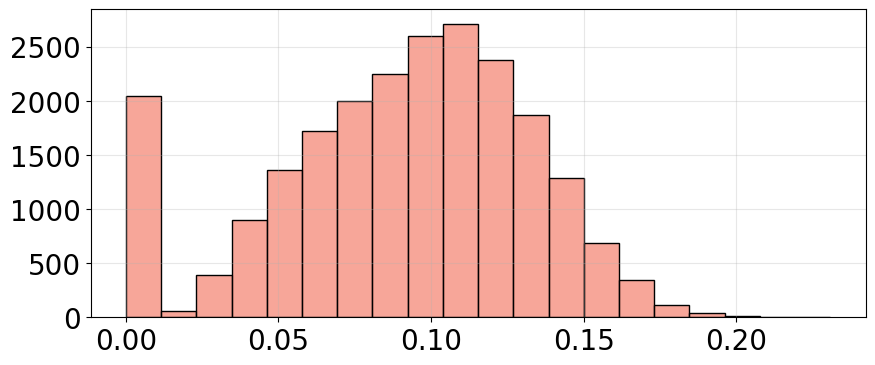

In [20]:
plot_norm_distribution(norm2)

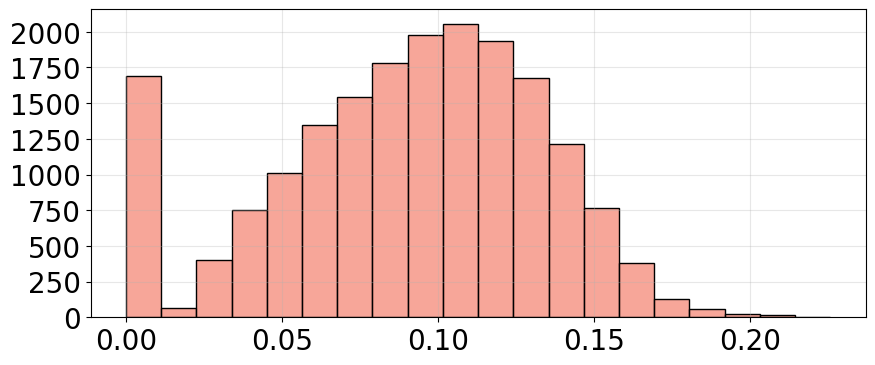

In [21]:
plot_norm_distribution(norm3)